# Programming session of Char RNN 

Please note that, this programming session is not made with the intention of building the best char RNN model available.  Rather, the idea is to build a rudimentary setup to explain the theory we discussed in the tutorial and train RNNs using PyTorch. Thus I don't use  batch training, dropouts, complex models like LSTMs, truncated backpropagation, dropouts, initialization hacks, learning rate decay and other optimizations. 

### Install PyTorch 0.4 with CUDA support

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [27]:
import torch
print("PyTorch Version: ",torch.__version__)
print("Cuda availability: ", torch.cuda.is_available())

PyTorch Version:  0.4.0
Cuda availability:  True


### Import PyTorch and other required libraries

In [0]:
import torch.nn as nn
import numpy as np
import random
from random import randint
from torch.nn.utils import clip_grad_value_
import torch.nn.functional as F

Device information will display the computation device, CPU or GPU. RNNs are infamous for their hunger for data and computation, GPUs are preferred for training RNNs.

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Get data

Once run, this will allow you to manually select the path on local drive for file you wish to upload. Here we are using tiny shakespheare dataset which can be downloaded from [here](https://github.com/karpathy/char-rnn/raw/master/data/tinyshakespeare/input.txt).


In [30]:
from google.colab import files
uploaded = files.upload()
for train in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=train, length=len(uploaded[train])))

Saving tiny_shakespheare.txt to tiny_shakespheare (2).txt
User uploaded file "tiny_shakespheare.txt" with length 1115394 bytes


### Process data

Here we are processing the data read from our input text file. 

1. First we get the number of characters present in the entire dataset.  This set has english alphabets, special characters, space and next line .  Can you spot the next line (`\n`) on print? ;)

2. Count of this entire set is called the `vocab_size`.  This parameter has significance as we move along. 

3. Second, we generated two dictionaries. One for mapping characters to IDs and the other of mapping vice-versa. Why they are required? Let's see later. 


In [32]:
# data I/O
data = open('tiny_shakespheare.txt', 'r').read() # should be simple plain text file

chars = list(set(data))
print("All available characters: ", "".join(chars))

data_size, vocab_size = len(data), len(chars)

print('\n1. Data has {} characters, in which {} unique.'.format(data_size, vocab_size))

print("2. Vocabulary size is ", vocab_size)

letterToIndex = { ch:i for i,ch in enumerate(chars)}
print("3. Index of A is ", letterToIndex['A'])

indexToChar = { i:ch for i,ch in enumerate(chars)}
print("4. Character with 10 as index is ", indexToChar[10])

print("\nA chunk of input data\n====================================\n")
print(data[5240:6900])


All available characters:  FC oSsyvf,RWAYXQkg
:ld;pwHBPZKeG?imN'UM&Ih.O-TEjuVxbzLJa$n3rDc!qt

1. Data has 1115394 characters, in which 65 unique.
2. Vocabulary size is  65
3. Index of A is  12
4. Character with 10 as index is  R

A chunk of input data

ould by the cormorant belly be restrain'd,
Who is the sink o' the body,--

MENENIUS:
Well, what then?

First Citizen:
The former agents, if they did complain,
What could the belly answer?

MENENIUS:
I will tell you
If you'll bestow a small--of what you have little--
Patience awhile, you'll hear the belly's answer.

First Citizen:
Ye're long about it.

MENENIUS:
Note me this, good friend;
Your most grave belly was deliberate,
Not rash like his accusers, and thus answer'd:
'True is it, my incorporate friends,' quoth he,
'That I receive the general food at first,
Which you do live upon; and fit it is,
Because I am the store-house and the shop
Of the whole body: but, if you do remember,
I send it through the rivers of your blood,
Even to the

### Functions required

Here we define all the required functions in favor of training and testing our language model. 

* `lineToInputTensor` 

This function help us to convert a line of text to the mathematical representation of a tensor. The tensor dimensions are `[number of RNN cells x size of the batch x number of letters]`. This is a convention for convenience while standard RNN cell of PyTorch. Though, here we are using our own custom model for RNN to explain the equations, we follow this convention. 

Since we don't use batch training here, the dimensions change to `[number of RNN cells x 1 x number of letters]`. 


* `lineToTargetTensor` 

This function helps to convert the target sentence to a tensor with it's IDs. Why not one-hot vectors? We use `CrossEntropyLoss` as loss function for our model. PyTorch expect target of it to be a `LongTensor` or a tensor with integer values.



In [0]:
def lineToInputTensor(line, vocab_size):
    """
    Turn a input line of string into a <seq_length x 1  x number of letters> tensor of one-hot letter vectors
    """
    tensor = torch.zeros(len(line), 1, vocab_size)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex[letter]] = 1
    return tensor


def lineToTargetTensor(line):
    """
    Turn a output line of string into a <lenght of the line x 1 > tensor with it's respective id numbers
    """
    tensor = torch.LongTensor(len(line))
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex[letter]
    return tensor.unsqueeze(-1)

def sample(model, input_hidden_state, starting_letter, num_samples):
    
    # Sample to understand the improvement
    output_string = ""
    input_vector = lineToInputTensor(starting_letter, vocab_size).to(device)
    
    for i in range(num_samples):
        # Forward propagate RNN 
        output, input_hidden_state = model(input_vector[0], input_hidden_state)

        # Sample a word id
        prob = output.exp()
        char_id = torch.multinomial(prob, num_samples=1).item()

        # Fill input with sampled word id for the next time step
        input_vector = lineToInputTensor(indexToChar[char_id], vocab_size).to(device)

        # File write
        char = indexToChar[char_id]
        char = '\n' if char == '.' else char + ''
        output_string += char
    return output_string

In [10]:
# Converting a line of text to a tensor

print(lineToInputTensor("Sleeba", vocab_size))

print("\nTensor shape: ",lineToInputTensor("Sleeba", vocab_size).shape)

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
  

In [11]:
# Convert the target to a tensor

print(lineToTargetTensor("Sleeba"))
print("\nTensor shape: ",lineToTargetTensor("Sleeba").shape)

tensor([[  50],
        [  75],
        [ 109],
        [ 109],
        [  52],
        [  38]])

Tensor shape:  torch.Size([6, 1])


In [0]:
# Store all the lines to a single string/corpus, so that we can seek through this string during each epoch.

lines = ""
with open('tiny_shakespheare.txt', 'r') as f:
# with open('les_miserables.txt', 'r') as f:
    for line in f:
        lines += line

In [0]:
class DetailedRNN(nn.Module):
    """
    PyTorch gives us the freedom for creating the custom models by inheriting nn.Module.
    We are going to create our RNN cell rather than using inbuilt RNN cell of PyTorch. 
    
    """
    def __init__(self, input_size, hidden_size, output_size):
        
        super(DetailedRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
#         self.tanh = nn.Tanh()
#         self.relu = nn.ReLU()
#         self.leaky_relu = nn.LeakyReLU()
        self.selu = nn.SELU();   # You can try various activations like ReLU, Leaky ReLU, SeLU etc. to improve the model. 
        self.i2h = nn.Linear(self.input_size + self.hidden_size, self.hidden_size) # I've concatenated first equation of RNN to build a single big matrix. It's simple linear algebra.
        self.i2o = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        # Forward pass of our RNN cell
        
        combined = torch.cat((input, hidden), 1)
        hidden_layer = self.i2h(combined)
        hidden_layer = self.selu(hidden_layer)
        output = self.i2o(hidden_layer)
        output = self.softmax(output)
        return output, hidden_layer
    
    def init_hidden(self):
        """
        Initialize hidden states and cell states to zeros
        """
        return torch.zeros(1, hidden_size)

In [0]:
# Hyper-parameters (Play with these values to build various models.)

hidden_size = 128 # No of hidden nuerons in a cell 
seq_length = 30   # No of time steps we're unfolding the RNN to. 
learning_rate = 0.001 # Fixed learning rate. You may try a decaying one. 
num_samples = 300  # No of characters we sample every now and then, to understand the changes. 
num_epochs = 5 # Number of times we are going to traverse through the entire corpus.

In [0]:
# Initialize the model 

model = DetailedRNN(vocab_size, hidden_size, vocab_size).to(device)

# Initialize loss and optimizer

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
# Train the model
# Set initial hidden and cell states

loss_list = [] # A list to monitor loss at every 1000th step. Later, this list will be used to plot the Loss vs Steps. 
num_steps = len(lines) // seq_length  # How many total time steps? If you've got the concept, then the equation is understood. 
lines = lines[:num_steps * seq_length+1] # We slice out that incomplete tail of lines which has a length less than seq_length


for epoch in range(num_epochs):
    
    # We initialize hidden_state at the beginning of every epoch. Why? 
    # When an epoch starts, the seeking through the entire corpus restarts. 
    # So it doesn't have a previous state anymore. Thus we initialize it to zero. 
    # This hidden_state is modified continuously as we seek along the corpus during an epoch.  
    
    step = 0
    hidden_state = model.init_hidden().to(device) 
    
    for i in range(0, num_steps * seq_length, seq_length):

        # Get sequence length inputs and targets
        # Eg. 

        # input = Sleeba Paul is a good boy
        # Target = leeba Paul is a good boy. 
        # We map `S` to `l`, `l` to `e` and finally `y` to `.`
        # Length of this sequence we consider once is defined by `seq_length`
        # This is how we seek through the entire text corpus during an epoch. 

        input_line = lines[i:i+seq_length]
        inputs = lineToInputTensor(input_line, vocab_size).to(device)

        targets_line = lines[(i+1):(i+1)+seq_length]
        targets = lineToTargetTensor(targets_line).to(device)

        loss = 0
        optimizer.zero_grad() # This is important since we want to reset the gradients at beginning of each sequence.

        for idx in range(len(input_line)):
            # Forward pass
            
            outputs, hidden_state = model(inputs[idx], hidden_state) # Very next character is predicted with the help of hidden_state and current input. 
            loss += criterion(outputs, targets[idx])  # Note that, we are updating weights at the end of a complete sequence, not at every character step

        loss.backward()  # Backpropagation through time is just a line of code in PyTorch ;)
        
        clip_grad_value_(model.parameters(), 5) # Clipping the gradient above the range of [-5, 5] to reduce exploding gradient effect. 
        
        optimizer.step() # Update weights

        # The following step is really really important! We are considering a sequence at once and optimize the loss from it.
        # For each sequence, there will be a hidden_state passed initially. 
        # At the very beginning it is a zero tensor. As we progress, this tensor will be changing continously and backpropagation will give the gradients to update hidden_state. 
        # In first sequence this is fine, but as steps goes up, the computation graph gets bigger and bigger. 
        # Eg. At step 10000, the optimizer has to go 10000 steps back to get the gradient's value !!!!
        # This can result in both vanishing and exploding gradient. 
        # So, we detach hidden_state from our computation graph after each sequence, optimizer has to go up to the beginning of current sequence. 
        # By detaching hidden_state from main computation graph, we treat it as a constant input when starting a sequence.
        # This technique is called truncated backpropagation i.e. we don't traverse whole computation graph, but a truncation of it.  

        hidden_state = hidden_state.detach() 

        # Sample at every step of 10000 steps
        step = (i+1) // seq_length
        if step % 10000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Learning rate: {}'.format(epoch+1, num_epochs, step, num_steps, loss.item(), learning_rate))
            starting_letter = random.choice(list(indexToChar.values()))
            print("Randomly selected starting letter for sampling: {}".format(starting_letter))

            print("_________________________________________________\n")

            output_string = sample(model, hidden_state, starting_letter, num_samples)
            print(starting_letter + output_string)
            print("===============================================================\n")

        if step % 1000 == 0:
            loss_list.append(float(loss))
            
    # Save the model checkpoint after each epoch
    torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [0/37179], Loss: 125.1162, Learning rate: 0.001
Randomly selected starting letter for sampling: S
_________________________________________________

SI&rM
QbqNwruE$aaYoLA x&$'UwW?JBEyuU
bt&JYdzyRMJDEW3wA
N co,Xs'DNw
oWtG&'&NsTdmQrIP
Odq-sJNvffg-CkcqnoB,
B3YLOA
DqrjfGd$i;ZejlxQgY'vWCejclNoJRYf?bNlmUztxd,Hzx-omDXSQbg?aNYrPY Q$:LI'we-Ek3dVxRs?Y!i,qPYqFjpJ$lv,iHoYeGcKiYgGAmcDlv&$p3nBCVvya
mHrAVSBnHSGgCM?ke:c-qUlUS?-CF3$XqbQ;&FToRPM;IK!QVeQEtLPomQxYT&

Epoch [1/5], Step [10000/37179], Loss: 77.0550, Learning rate: 0.001
Randomly selected starting letter for sampling: -
_________________________________________________

- mist baing porsthre, and
Gavost, more


KING RICHERDETIN:
Rileres, if comainderty forst
AnETHard,
Rich, ghagh othlu bd me fordisbu, math soprow,
AmThe ryollog


TERHA
DuRIA:
SI sringanchapgoEd
Dond
Gues bmothe?

ThRod, tht on maran oof gevonde therete, btoof you sopr'd an Hae t ondily

Un?
Ubel in 

Epoch [1/5], Step [20000/37179], Loss: 60.4574, Learning 

s so ther,
as sperthins she meast he--
For not comass and aslond beepe you weaply


ANTONIO:
Nayys of sirs,
All steaty,
Did sCraze strame

O Pivess: this crieits I deebs ocer liks' wich; ayst
AN I you laugh asbia temse--woel by mentreem medies!
SEBeinch sphangils


SEBASTIAN:
What you boyess happ'd t

Epoch [5/5], Step [10000/37179], Loss: 75.5531, Learning rate: 0.001
Randomly selected starting letter for sampling: S
_________________________________________________

S frain Messel be twe


KING RIVING:
I will moreen
dirget bir thou womnard'd sor friff

Seas!

Tcuceit, tead norchatt
And Good for colr;
Who caishile suildife as to and
Sair mishowing,
And, he hander Firth or be rireticessland hem me thoir:
Beting, ark


CATESDYOFE:
Yorking butthy, anch the fartt
Fro

Epoch [5/5], Step [20000/37179], Loss: 50.2761, Learning rate: 0.001
Randomly selected starting letter for sampling: .
_________________________________________________

.
So the bronglatous shoy

That
 his, beont, ente you 

In [44]:
num_samples = 5000     # number of words to be sampled
sample_text_generated = ""

# Test the model 
# Generate a chunk of text and write it to sample.txt

with torch.no_grad():
    with open('sample.txt', 'w') as f:
        # Set intial hidden ane cell states
        hidden_state = model.init_hidden().to(device)
        # Select one word id randomly
        starting_letter = random.choice(list(indexToChar.values()))
        print("Randomly selected starting letter for sampling: {}".format(starting_letter))
        
        input = lineToInputTensor(starting_letter, vocab_size).to(device)
        prob = torch.ones(vocab_size)
        for i in range(num_samples):
            # Forward propagate RNN 
            output, hidden_state = model(input[0], hidden_state)

            # Sample a word id
            prob = output.exp()
            char_id = torch.multinomial(prob, num_samples=1).item()

            # File write
            char = indexToChar[char_id]
            char = '\n' if char == '.' else char + ''
            sample_text_generated += char
            f.write(char)
            if (i+1) % 1000 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, 'sample.txt'))
                
            # Fill input with sampled word id for the next time step
            input = lineToInputTensor(indexToChar[char_id], vocab_size).to(device)
print("\nGenerated text\n------------------------------------------------------")
print(sample_text_generated)


Randomly selected starting letter for sampling: R
Sampled [1000/5000] words and save to sample.txt
Sampled [2000/5000] words and save to sample.txt
Sampled [3000/5000] words and save to sample.txt
Sampled [4000/5000] words and save to sample.txt
Sampled [5000/5000] words and save to sample.txt

Generated text
------------------------------------------------------
emo, or owle,
My dony long thought all


GONZALO:
What, I divid a word me, at younds
that will they I done; I daggntth, afore, you shell;
I mest, thou't-cainst of a getemed thas I sthe his, I am I wide sord, your thattred though was ento?

ANTONIO:
Whaigh I wore, I spow-faty see
And thas I must yon I done edeal to let my hoar you ir reathats: I leep,
We suragt
 Say, at geve Matial, are you ore your
As thoust must of thy


SEBASTINTO:
I do astains sinct the groken whank you no most eying,--at forts on theink, to solltt thou art yet so lange
 Go tinght innosts to sprysem
And'; this thee
Your, good my whom! What it
The grejestule

# Inference 

As we see, from scratch, RNNs learned the conversation structure, names of characters, capital letters for sentence starting, questions ending with question marks, salutations followed by comma and many other things. 

Yes, most of the dialogues are still gibberish. But this is the rudimentary implementation of RNNs. Also,  note that our data is too small (1MB is already considered very small) the RNN won't learn very effectively. Conversely if our data is large (more than about 2MB), it will work significantly better. 

Considering all these points,  RNNs have done a pretty good job. Most importantly, we learned the concepts really well. There are so many optimization can be brought into this model and come up with exceptional models that are creative and maintain context really well. 

Below is the loss v/s iterations graph. 

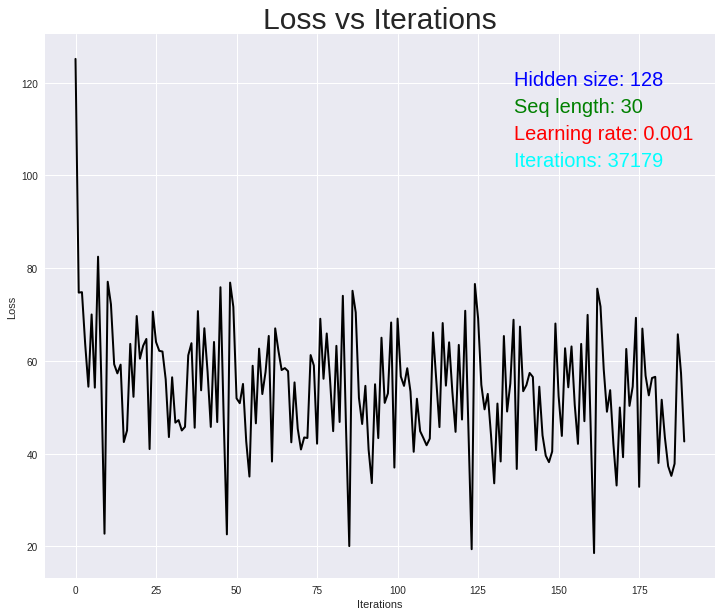

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

fig, ax = plt.subplots()
sns.set_style("ticks")
sns.set_context("poster")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations", fontsize=30)
# x = list(range(1, len(lines), seq_length))
y = loss_list
ax.text(0.7, 0.9, 'Hidden size: {}'.format(hidden_size),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Blue', fontsize=20)
ax.text(0.7, 0.85, 'Seq length: {}'.format(seq_length),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Green', fontsize=20)
ax.text(0.7, 0.80, 'Learning rate: {}'.format(learning_rate),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Red', fontsize=20)
ax.text(0.7, 0.75, 'Iterations: {}'.format(num_steps),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Cyan', fontsize=20)
plt.plot( y, color='black', linewidth = 2)
fig.set_size_inches(12, 10)
plt.savefig("loss_iter_graph.png", dpi=600)
plt.show()

In [0]:
files.download('sample.txt')

In [0]:
files.download("loss_iter_graph.png")

In [0]:
files.download('model.ckpt')